## 测量模型推理时间
测量模型推理时间是指模型在GPU上对单个实例进行推理的时间。在进行模型推理时间估计时有以下几点需要注意：
1. 运行向前推理存在一定随机性，因此需要通过多次运行进行统计，减少实验误差。一般重复1000次观察结果。
2. GPU运算是异步执行的，通过torch.cuda.synchronize()进行CPU和GPU设备的同步，保证计算是在GPU程序运行之后进行的。
3. GPU需要warm up，因为GPU有几种不同的电源状态，可以通过提前使用GPU设备，避免驱动加载和初始化设备带来的时间损耗。
4. 数据和模型提前运输到指定设备，在推理时进行设备间数据传输将增加时耗。

### 1. 使用time.perf_counter()

使用预训练模型参数：False
use_atten: True
warm up ...
begin to 推理 ...


100%|██████████| 1000/1000 [00:08<00:00, 121.62it/s]

inference takes average 8.19ms for one image


(       timing anylize
 count     1000.000000
 mean         8.191133
 std          0.043529
 min          8.142556
 25%          8.161858
 50%          8.173842
 75%          8.206706
 max          8.554600,
 <AxesSubplot:ylabel='Density'>)

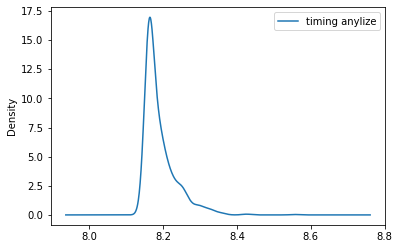

In [4]:
import time
import torch
from torchvision.models import resnet18
from torch.backends import cudnn
import tqdm
import numpy as np
import pandas as pd
from one_model_trainer import LitModel
cudnn.benchmark = True

# 1.构造模型
check_point='/home/mby/computer_vision/mer/long_short_action/lightning_logs/casme2/frames-short_action-loso-5classes/version_11/checkpoints/fold0-epoch=2-acc=0.5882-uf1=0.5248-uar=0.6889.ckpt'
model = LitModel.load_from_checkpoint(check_point)
model.eval()

# 2.构造数据
dummy_input = torch.rand(1,3, 8, 224, 224)

# 3.移动到指定设备
device=torch.device('cuda:0')
model=model.to(device)
dummy_input=dummy_input.to(device)

# 4. warumup 
print('warm up ...')
with torch.no_grad():
    for _ in  range(10):
        _ = model(dummy_input)

# 5.推理
print('begin to 推理 ...')
repetitions=1000
timings = np.zeros(repetitions)

if str(device).__contains__('cuda'):
    torch.cuda.synchronize(device)  
 
for i in  tqdm.tqdm(range(repetitions)):
    start = time.perf_counter() #相比time()更精准
    model(dummy_input)
    if str(device).__contains__('cuda'):
        torch.cuda.synchronize(device)
    end = time.perf_counter()
    timings[i]=end - start
 
# 6. 统计
time_per_img=timings.sum()/repetitions
print('inference takes average {:.2f}ms for one image'.format(time_per_img*1000))

t=pd.DataFrame({ 'timing anylize':timings*1000}).describe()
t,pd.DataFrame({ 'timing anylize':timings*1000}).plot.kde()

### 2. 使用 torch.cuda.event
参考：https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f

用torch.cuda.Event可以提供更准确的计时结果，因为它们是专门用于测量GPU操作的时间戳。与time.perf_counter()或time.process_time()函数不同，torch.cuda.Event不受CPU和GPU之间的同步或其他操作系统级别的干扰的影响，它保证所有计时工作都是在GPU上完成的。

warm up ...
warum up done
begin to inference ...


100%|██████████| 1000/1000 [00:02<00:00, 438.68it/s]

inference takes average 2.26ms for one image


(       timing anylize
 count     1000.000000
 mean         2.256789
 std          0.050967
 min          2.221696
 25%          2.230080
 50%          2.233344
 75%          2.265088
 max          2.593792,
 <AxesSubplot:ylabel='Density'>)

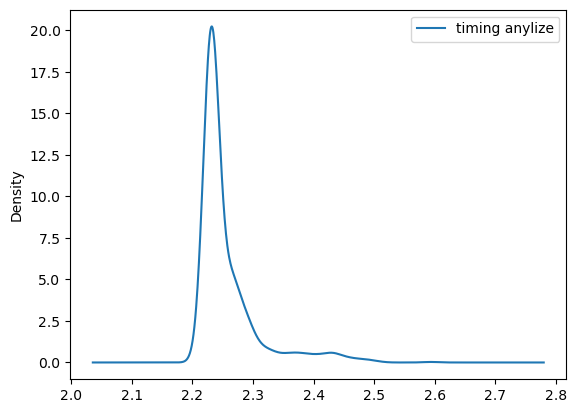

In [5]:
import numpy as np
import pandas as pd
from torchvision.models import resnet18
import torch
from torch.backends import cudnn
import tqdm
cudnn.benchmark = True

# 1.构造模型
model = resnet18()
model.eval()

# 2.构造数据
dummy_input = torch.rand(1, 3, 256, 256)

# 3.移动到指定设备
device=torch.device('cuda:0')
model=model.to(device)
dummy_input=dummy_input.to(device)

# 4. 预热, GPU 平时可能为了节能而处于休眠状态, 因此需要预热
print('warm up ...')
with torch.no_grad():
    for _ in  range(10):
        _ = model(dummy_input)
print('warum up done')

# 5. 推理

print('begin to inference ...')
# synchronize 等待所有 GPU 任务处理完才返回 CPU 主线程
torch.cuda.synchronize(device)

# 设置用于测量时间的 cuda Event, 这是PyTorch 官方推荐的接口,理论上应该最靠谱
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# 初始化一个时间容器
repetitions=1000
timings = np.zeros(repetitions)

# 设置当前设备，用于
torch.cuda.set_device(device)
# s= torch.cuda.current_stream(device)
# torch.cuda.set_stream(s)
# print(torch.cuda.current_device())
# print(torch.cuda.current_stream())
with torch.no_grad():
    for rep in tqdm.tqdm(range(repetitions)):
        starter.record()
        model(dummy_input)
        ender.record()
        torch.cuda.synchronize() # 等待GPU任务完成
        curr_time = starter.elapsed_time(ender) # 从 starter 到 ender 之间用时,单位为毫秒
        timings[rep] = curr_time

# 6. 统计
time_per_img=timings.sum()/repetitions
print('inference takes average {:.2f}ms for one image'.format(time_per_img))

t=pd.DataFrame({ 'timing anylize':timings}).describe()
t,pd.DataFrame({ 'timing anylize':timings}).plot.kde()

## 测量模型吞吐量

模型吞吐量定义为单位时间内模型可以处理的最大输入实例。
与计算模型推理时间不同的是，吞吐量要求最大可能的并行，依赖数据、模型、设备等。因此，对模型吞吐量的测量分为两步：
1. 搜索当前GPU运行的最大Batch_size，与模型大小、GPU设备、输入数据大小相关。
2. 给定这个最佳的批处理大小，测量网络在单位时间内处理的实例数量（计算吞吐量），一般可以重复100次进行数据统计。

### 估计当前GPU所允许的最大Batch_size

In [2]:
from torchvision.models import resnet18
import torch
device=torch.device('cuda:0')

model = resnet18()
model.eval()
model=model.to(device)

# 二分估算最大batch size
batch_size_lower = 1
batch_size_upper = 4096
last_success_batch_size = None
while batch_size_lower <= batch_size_upper:
    batch_size_mid = (batch_size_lower + batch_size_upper) // 2
    try:
        torch.cuda.empty_cache() #每次进行模型评估之前，会先清除GPU缓存，从而确保内存占用被正确地计算。
        x = torch.randn((batch_size_mid, 3, 256, 256), device=device)
        with torch.no_grad():
            model(x)
        print(f"Batch size {batch_size_mid} is successful.")
        last_success_batch_size = batch_size_mid
        batch_size_lower = batch_size_mid + 1
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Batch size {batch_size_mid} is too large. Reduce the batch size.")
            batch_size_upper = batch_size_mid - 1
print(f"Maximum batch size: {last_success_batch_size}")

Batch size 2048 is too large. Reduce the batch size.
Batch size 1024 is too large. Reduce the batch size.
Batch size 512 is successful.
Batch size 768 is successful.
Batch size 896 is too large. Reduce the batch size.
Batch size 832 is successful.
Batch size 864 is too large. Reduce the batch size.
Batch size 848 is too large. Reduce the batch size.
Batch size 840 is too large. Reduce the batch size.
Batch size 836 is successful.
Batch size 838 is too large. Reduce the batch size.
Batch size 837 is successful.
Maximum batch size: 837


###  使用 torch.cuda.event

In [3]:
import numpy as np
import pandas as pd
from torchvision.models import resnet18
import torch
from torch.backends import cudnn
import tqdm
cudnn.benchmark = True
device=torch.device('cuda:0')

# 1.构造模型
model = resnet18()
model.eval()

# 2.构造数据
def get_max_batch_size(model,data_size,device):
    """二分查找获取当前设备、模型\数据大小下，允许并行的最大数据的batchsize.
    """
    model.eval()
    model=model.to(device)
    # 二分估算最大batch size
    batch_size_lower = 1
    batch_size_upper = 4096
    last_success_batch_size = None
    while batch_size_lower <= batch_size_upper:
        batch_size_mid = (batch_size_lower + batch_size_upper) // 2
        try:
            torch.cuda.empty_cache() #每次进行模型评估之前，会先清除GPU缓存，从而确保内存占用被正确地计算。
            x = torch.randn((batch_size_mid, *data_size), device=device)
            with torch.no_grad():
                model(x)
            print(f"Batch size {batch_size_mid} is successful.")
            last_success_batch_size = batch_size_mid
            batch_size_lower = batch_size_mid + 1
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"Batch size {batch_size_mid} is too large. Reduce the batch size.")
                batch_size_upper = batch_size_mid - 1
    print(f"Maximum batch size: {last_success_batch_size}")
    return last_success_batch_size

optimal_batch_size=get_max_batch_size(model,(3,256,256),device)
dummy_input = torch.rand(optimal_batch_size, 3, 256, 256)

# 3.移动到指定设备
model=model.to(device)
dummy_input=dummy_input.to(device)


# 4. 预热, GPU 平时可能为了节能而处于休眠状态, 因此需要预热
print('warm up ...')
with torch.no_grad():
    for _ in  range(10):
        _ = model(dummy_input)
print('warum up done')

# 5. 推理
print('begin to inference ...')
# synchronize 等待所有 GPU 任务处理完才返回 CPU 主线程
torch.cuda.synchronize(device)

# 设置用于测量时间的 cuda Event, 这是PyTorch 官方推荐的接口,理论上应该最靠谱
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# 初始化一个时间容器
timings = np.zeros(repetitions)
repetitions=300

# 设置当前设备，用于
torch.cuda.set_device(device)
# s= torch.cuda.current_stream(device)
# torch.cuda.set_stream(s)
# print(torch.cuda.current_device())
# print(torch.cuda.current_stream())
with torch.no_grad():
    for rep in tqdm.tqdm(range(repetitions)):
        starter.record()
        model(dummy_input)
        ender.record()
        torch.cuda.synchronize() # 等待GPU任务完成
        curr_time = starter.elapsed_time(ender) # 从 starter 到 ender 之间用时,单位为毫秒
        timings[rep] = curr_time

# 6. 计算
total_time=timings.sum()/1000 # ms -> s
Throughput = (repetitions*optimal_batch_size)/total_time
print('Final Throughput:',Throughput)

Batch size 2048 is too large. Reduce the batch size.
Batch size 1024 is too large. Reduce the batch size.
Batch size 512 is successful.
Batch size 768 is successful.
Batch size 896 is too large. Reduce the batch size.
Batch size 832 is successful.
Batch size 864 is too large. Reduce the batch size.
Batch size 848 is too large. Reduce the batch size.
Batch size 840 is too large. Reduce the batch size.
Batch size 836 is successful.
Batch size 838 is too large. Reduce the batch size.
Batch size 837 is successful.
Maximum batch size: 837
warm up ...
warum up done
begin to inference ...


100%|██████████| 300/300 [02:53<00:00,  1.73it/s]

Final Throughput: 1446.0827307545437
